In [1]:

import os
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.applications import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.optimizers import Adam


def load_dataset(validation_split=0.2,dec_factor=10):
    # Load the CIFAR-10 dataset
    (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


    # Reduce the number of images by a factor of dec_factor
    train_images = train_images[::dec_factor]  # Take every Nth image
    train_labels = train_labels[::dec_factor]  # Corresponding labels
    test_images = test_images[::dec_factor]
    test_labels = test_labels[::dec_factor]


    # Split the training data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=validation_split, random_state=42)

    # Normalize pixel values to be between 0 and 1
    train_images, val_images, test_images = train_images / 255.0, val_images / 255.0, test_images / 255.0
    
    # Convert labels to one-hot encoding
    train_labels = to_categorical(train_labels, 10)
    val_labels = to_categorical(val_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_images, train_labels, val_images, val_labels, test_images, test_labels


def create_model():
    image_size = 128
    base_model = MobileNet( input_shape = (image_size,image_size,3),
                            include_top=False,
                             weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([        
        Resizing(image_size, image_size, interpolation="nearest", input_shape=train_images.shape[1:]),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax')
    ])

    # Specify the learning rate
    
    # Instantiate the Adam optimizer with the default learning rate
    optimizer = Adam()

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


2024-10-27 15:46:54.804215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/shaicahana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:

def plot_train_vs_val_accuracy(history):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    t = np.array(history.epoch)
    colors = {}
    colors['loss'] = 'r'
    colors['val_loss'] = '#FEA510'
    colors['accuracy'] = 'green'
    colors['val_accuracy'] = 'b'

    # plt.figure(figsize=(10, 5))
    i = 1
    for elem in history.history.keys():
        # i can check if the string contains a substring for subplot
        if i%2 ==0:
            plt.subplot(1,2,1)
        else:
            plt.subplot(1,2,2)

        y = np.array(history.history[elem])
        c = str(colors[elem])
        l = str(elem)
        plt.plot(np.array(t),np.array(y),color=c,label=l)
        i += 1

        plt.legend()
        # plt.show()
        plt.xlabel('Epochs')
        plt.ylabel('Amplitude')
    return


Epoch 1/5
125/125 [==============================] - 26s 192ms/step - loss: 1.2482 - accuracy: 0.5765 - val_loss: 0.7876 - val_accuracy: 0.7290
Epoch 2/5
125/125 [==============================] - 23s 181ms/step - loss: 0.6134 - accuracy: 0.7928 - val_loss: 0.6474 - val_accuracy: 0.7810
Epoch 3/5
125/125 [==============================] - 22s 176ms/step - loss: 0.4762 - accuracy: 0.8393 - val_loss: 0.5861 - val_accuracy: 0.7930
Epoch 4/5
125/125 [==============================] - 21s 167ms/step - loss: 0.3914 - accuracy: 0.8695 - val_loss: 0.5684 - val_accuracy: 0.8000
Epoch 5/5
125/125 [==============================] - 21s 167ms/step - loss: 0.3318 - accuracy: 0.9007 - val_loss: 0.5636 - val_accuracy: 0.8010
32/32 - 4s - loss: 0.6273 - accuracy: 0.7750 - 4s/epoch - 133ms/step
Test accuracy: 0.7749999761581421, Test loss: 0.6273046135902405


/var/folders/wf/4y84mfzj64v_q85n5q_ggwcr0000gn/T/ipykernel_33732/2019799912.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)
/var/folders/wf/4y84mfzj64v_q85n5q_ggwcr0000gn/T/ipykernel_33732/2019799912.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)
/var/folders/wf/4y84mfzj64v_q85n5q_ggwcr0000gn/T/ipykernel_33732/2019799912.py:18: MatplotlibDeprecationWarning: Adding an axes using th

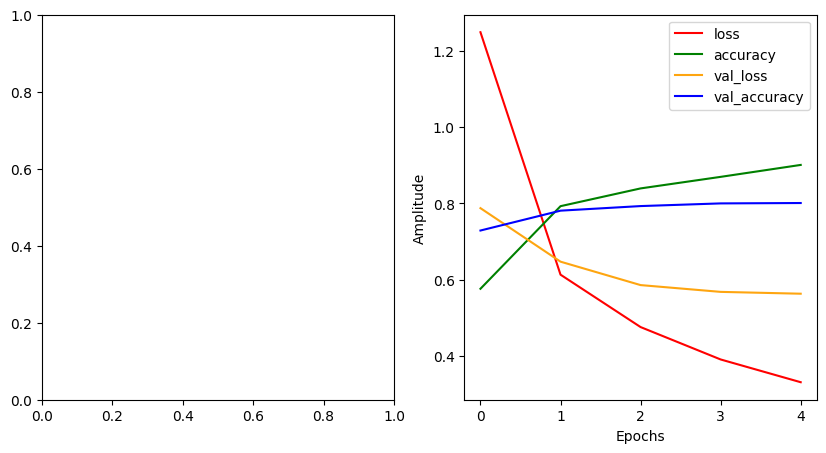

In [3]:
# Set the random seeds
os.environ['PYTHONHASHSEED'] = str(42)  # This variable influences the hash function's behavior in Python 3.3 and later.
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#Load the dataset
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_dataset()
#Create the backbone model that will be used to train
model = create_model()
#Do the actual training
history = model.fit(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels))
#Evaluate 
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

plot_train_vs_val_accuracy(history)